# Import

In [1]:
!pip install clean-text
!pip3 install pyenchant
!apt install enchant
!pip install demoji
!pip install underthesea
!pip install gradio
!pip install yellowbrick
!pip install imbalanced-learn
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.9 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171033 sha256=ee36e084bb01ee9f55d7101e5d89723a54a1b64c60d80770d9ede80462d18598
  Stored in directory: /root/.cache/pip/wheels/31/8a/8c/315c9e5d7773f74b33d5ed33f075b49c6eaeb7cedbb86e2cf8
Successfully built emoji
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 kB 1.2 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package enchant
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 557.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 41

In [ ]:
import pandas as pd
import numpy as np

from train_model import clean_text, clf_report



## áp dụng over-sampling
from imblearn.over_sampling import SVMSMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline


from sklearn.model_selection import GridSearchCV
from sklearn import set_config
from sklearn.pipeline import Pipeline as SKPipeline
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

import optuna
from optuna.samplers import TPESampler
from optuna.pruners import SuccessiveHalvingPruner


import warnings
warnings.simplefilter("ignore", UserWarning)
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package perluniprops to /root/nltk_data...
[nltk_data]   Unzipping misc/perluniprops.zip.


In [ ]:
def build_pipe(model, vectorizer, resampler=None):
  if resampler:
    pipe = ImbPipeline(
    steps=[('vect', vectorizer),
           ('ros', resampler),
           ('clf', model)]
  )

  else:
    pipe = SKPipeline(
    steps=[('vect', vectorizer),
           ('clf', model)]
  )

  return pipe

# Load data

In [ ]:
data = pd.read_csv("/content/preprocessed_data_7k.csv")[['Comment', 'sentiment']]
data.drop_duplicates(subset=['Comment'], inplace=True)
data = data.dropna()
X = data['Comment'].copy()
y = data['sentiment'].copy().replace(['Positive', 'Negative', 'Neutral'], [0,1,2])
#X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0, stratify=y)

FileNotFoundError: ignored

In [ ]:
import joblib
model = joblib.load("/content/sentiment_analysis_stacking_model.joblib")

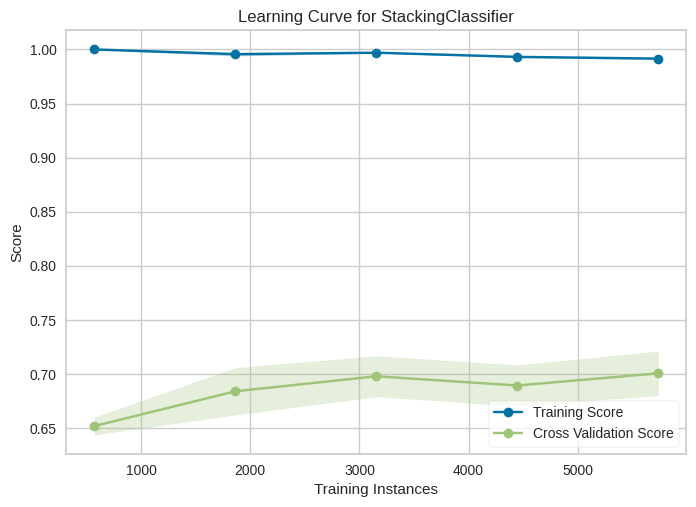

ValueError: ignored

In [ ]:
from yellowbrick.model_selection import learning_curve
print(learning_curve(model, X, y, cv=5, scoring='f1_macro'))

# Bài toán phân tích cảm xúc

## Baseline: MultinomialNB




In [ ]:
from sklearn.naive_bayes import MultinomialNB
baseline = build_pipe(MultinomialNB(), TfidfVectorizer())
cv = StratifiedKFold(n_splits=5)
print(cross_val_score(baseline, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean())
print(cross_val_score(baseline, X_train, y_train, cv=cv, scoring='f1_macro', n_jobs=-1).mean())

0.7212186392322988
0.5302248102635659


In [ ]:
from sklearn.naive_bayes import MultinomialNB
baseline = build_pipe(MultinomialNB(), CountVectorizer())
cv = StratifiedKFold(n_splits=5)
print(cross_val_score(baseline, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean())
print(cross_val_score(baseline, X_train, y_train, cv=cv, scoring='f1_macro', n_jobs=-1).mean())

0.7597171263075991
0.6291958140875351


## Hypertuning model

### Model Logistic Regression


```
TFIDF
{'vect__ngram_range': (1, 3),
 'vect__min_df': 0.0003836476236183987,
 'clf__C': 12.28756331139111,
 'clf__solver': 'lbfgs'}
```



In [ ]:
def objective(trial):

  params = {
        'vect__ngram_range': trial.suggest_categorical('vect__ngram_range', [(1,1), (2,2), (1,2), (1,3)]),
        'vect__min_df': trial.suggest_float('vect__min_df', 0, 0.1),
        'clf__C': trial.suggest_float('clf__C', 0.01, 100, log=True),
        'clf__solver': trial.suggest_categorical('clf__solver', ['newton-cg', 'lbfgs', 'liblinear'])
    }


  pipe = build_pipe(LogisticRegression(), TfidfVectorizer(max_df=0.95))

  pipe.set_params(**params)

  for step in range(5):
    cv = StratifiedKFold(n_splits=5)
    score = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
    trial.report(score, step)

    if trial.should_prune():
      raise optuna.TrialPruned()

    return score


pruner = SuccessiveHalvingPruner(min_resource=1, reduction_factor=2, min_early_stopping_rate=0)
study = optuna.create_study(sampler = TPESampler(seed=444),direction ='maximize', pruner=pruner)
study.optimize(objective, n_trials=100)

In [ ]:
print(study.best_trial)
study.best_params

FrozenTrial(number=62, state=TrialState.COMPLETE, values=[0.8002590127085675], datetime_start=datetime.datetime(2023, 6, 19, 3, 51, 25, 158031), datetime_complete=datetime.datetime(2023, 6, 19, 3, 51, 31, 672704), params={'vect__ngram_range': (1, 3), 'vect__min_df': 0.0003836476236183987, 'clf__C': 12.28756331139111, 'clf__solver': 'lbfgs'}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.8002590127085675}, distributions={'vect__ngram_range': CategoricalDistribution(choices=((1, 1), (2, 2), (1, 2), (1, 3))), 'vect__min_df': FloatDistribution(high=0.1, log=False, low=0.0, step=None), 'clf__C': FloatDistribution(high=100.0, log=True, low=0.01, step=None), 'clf__solver': CategoricalDistribution(choices=('newton-cg', 'lbfgs', 'liblinear'))}, trial_id=62, value=None)


{'vect__ngram_range': (1, 3),
 'vect__min_df': 0.0003836476236183987,
 'clf__C': 12.28756331139111,
 'clf__solver': 'lbfgs'}

In [ ]:
cv = StratifiedKFold(n_splits=5)
best_lr = build_pipe(LogisticRegression(), TfidfVectorizer(max_df=0.95))
best_params_lr = {'vect__ngram_range': (1, 3),
 'vect__min_df': 0.0003836476236183987,
 'clf__C': 12.28756331139111,
 'clf__solver': 'lbfgs'}
best_lr.set_params(**best_params_lr)

print(cross_val_score(best_lr, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean())
print(cross_val_score(best_lr, X_train, y_train, cv=cv, scoring='f1_macro', n_jobs=-1).mean())

0.8002590127085675
0.7105620297572174


In [ ]:
def objective(trial):

  params = {
        'vect__ngram_range': trial.suggest_categorical('vect__ngram_range', [(1,1), (2,2), (1,2), (1,3)]),
        'vect__min_df': trial.suggest_float('vect__min_df', 0, 0.1),
        'clf__C': trial.suggest_float('clf__C', 0.01, 100, log=True),
        'clf__solver': trial.suggest_categorical('clf__solver', ['newton-cg', 'lbfgs', 'liblinear'])
    }


  pipe = build_pipe(LogisticRegression(), TfidfVectorizer(max_df=0.95), SVMSMOTE(random_state=444))

  pipe.set_params(**params)

  for step in range(5):
    cv = StratifiedKFold(n_splits=5)
    score = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
    trial.report(score, step)

    if trial.should_prune():
      raise optuna.TrialPruned()

    return score


pruner = SuccessiveHalvingPruner(min_resource=1, reduction_factor=2, min_early_stopping_rate=0)
study = optuna.create_study(sampler = TPESampler(seed=444),direction ='maximize', pruner=pruner)
study.optimize(objective, n_trials=100)

In [ ]:
cv = StratifiedKFold(n_splits=5)
best_lr_svmsmote = build_pipe(LogisticRegression(), TfidfVectorizer(max_df=0.95), SVMSMOTE(random_state=444))

best_params_lr = {'vect__ngram_range': (1, 3),
 'vect__min_df': 0.0003836476236183987,
 'clf__C': 12.28756331139111,
 'clf__solver': 'lbfgs'}
best_lr_svmsmote.set_params(**best_params_lr)

print(cross_val_score(best_lr_svmsmote, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean())
print(cross_val_score(best_lr_svmsmote, X_train, y_train, cv=cv, scoring='f1_macro', n_jobs=-1).mean())

0.7918896861761909
0.7144602256241821


In [ ]:
def objective(trial):

  params = {
        'vect__ngram_range': trial.suggest_categorical('vect__ngram_range', [(1,1), (2,2), (1,2), (1,3)]),
        'vect__min_df': trial.suggest_float('vect__min_df', 0, 0.1),
        'clf__C': trial.suggest_float('clf__C', 0.01, 100, log=True),
        'clf__solver': trial.suggest_categorical('clf__solver', ['newton-cg', 'lbfgs', 'liblinear'])
    }


  pipe = build_pipe(LogisticRegression(), CountVectorizer(max_df=0.95))

  pipe.set_params(**params)

  for step in range(5):
    cv = StratifiedKFold(n_splits=5)
    score = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
    trial.report(score, step)

    if trial.should_prune():
      raise optuna.TrialPruned()

    return score


pruner = SuccessiveHalvingPruner(min_resource=1, reduction_factor=2, min_early_stopping_rate=0)
study = optuna.create_study(sampler = TPESampler(seed=444),direction ='maximize', pruner=pruner)
study.optimize(objective, n_trials=100)

In [ ]:
print(study.best_trial)
study.best_params

FrozenTrial(number=91, state=TrialState.COMPLETE, values=[0.7894724647704676], datetime_start=datetime.datetime(2023, 6, 19, 4, 32, 24, 532556), datetime_complete=datetime.datetime(2023, 6, 19, 4, 32, 29, 231959), params={'vect__ngram_range': (1, 3), 'vect__min_df': 0.00016981532436468667, 'clf__C': 0.8880857961996467, 'clf__solver': 'liblinear'}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.7894724647704676}, distributions={'vect__ngram_range': CategoricalDistribution(choices=((1, 1), (2, 2), (1, 2), (1, 3))), 'vect__min_df': FloatDistribution(high=0.1, log=False, low=0.0, step=None), 'clf__C': FloatDistribution(high=100.0, log=True, low=0.01, step=None), 'clf__solver': CategoricalDistribution(choices=('newton-cg', 'lbfgs', 'liblinear'))}, trial_id=91, value=None)


{'vect__ngram_range': (1, 3),
 'vect__min_df': 0.00016981532436468667,
 'clf__C': 0.8880857961996467,
 'clf__solver': 'liblinear'}

In [ ]:
cv = StratifiedKFold(n_splits=5)
best_lr_ct = build_pipe(LogisticRegression(), CountVectorizer(max_df=0.95))

best_params_lr = {'vect__ngram_range': (1, 3),
 'vect__min_df': 0.00016981532436468667,
 'clf__C': 0.8880857961996467,
 'clf__solver': 'liblinear'}
best_lr_ct.set_params(**best_params_lr)

print(cross_val_score(best_lr_ct, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean())
print(cross_val_score(best_lr_ct, X_train, y_train, cv=cv, scoring='f1_macro', n_jobs=-1).mean())

0.7894724647704676
0.6703858927969529


In [ ]:
def objective(trial):

  params = {
        'vect__ngram_range': trial.suggest_categorical('vect__ngram_range', [(1,1), (2,2), (1,2), (1,3)]),
        'vect__min_df': trial.suggest_float('vect__min_df', 0, 0.1),
        'clf__C': trial.suggest_float('clf__C', 0.01, 100, log=True),
        'clf__solver': trial.suggest_categorical('clf__solver', ['newton-cg', 'lbfgs', 'liblinear'])
    }


  pipe = build_pipe(LogisticRegression(), CountVectorizer(max_df=0.95), SVMSMOTE(random_state=444))

  pipe.set_params(**params)

  for step in range(5):
    cv = StratifiedKFold(n_splits=5)
    score = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
    trial.report(score, step)

    if trial.should_prune():
      raise optuna.TrialPruned()

    return score


pruner = SuccessiveHalvingPruner(min_resource=1, reduction_factor=2, min_early_stopping_rate=0)
study = optuna.create_study(sampler = TPESampler(seed=444),direction ='maximize', pruner=pruner)
study.optimize(objective, n_trials=100)

In [ ]:
cv = StratifiedKFold(n_splits=5)
best_lr_ct_svmsmote = build_pipe(LogisticRegression(), CountVectorizer(max_df=0.95), SVMSMOTE(random_state=444))

best_params_lr = {'vect__ngram_range': (1, 3),
 'vect__min_df': 0.00016981532436468667,
 'clf__C': 0.8880857961996467,
 'clf__solver': 'liblinear'}
best_lr_ct_svmsmote.set_params(**best_params_lr)

print(cross_val_score(best_lr_ct_svmsmote, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean())
print(cross_val_score(best_lr_ct_svmsmote, X_train, y_train, cv=cv, scoring='f1_macro', n_jobs=-1).mean())

0.7660364830984697
0.6948769898341738


### Tham số tối ưu

### Model SVC


```
TFIDF
{'vect__ngram_range': (1, 2),
 'vect__min_df': 0.001557968668066791,
 'clf__C': 1.6475049890006868,
 'clf__gamma': 1,
 'clf__kernel': 'rbf'}
```



In [ ]:
from sklearn.svm import SVC

In [ ]:
def objective(trial):

  params = {
        'vect__ngram_range': trial.suggest_categorical('vect__ngram_range', [(1,1), (2,2), (1,2), (1,3)]),
        'vect__min_df': trial.suggest_float('vect__min_df', 0, 0.1),
        'clf__C': trial.suggest_float('clf__C', 0.01, 100, log=True),
        'clf__gamma': trial.suggest_categorical('clf__gamma', ['scale', 'auto', 1, 0.1, 0.01, 0.001]),
        'clf__kernel': trial.suggest_categorical('clf__kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    }


  pipe = build_pipe(SVC(random_state=444), TfidfVectorizer(max_df=0.95))


  pipe.set_params(**params)

  for step in range(5):
    cv = StratifiedKFold(n_splits=5)
    score = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
    trial.report(score, step)

    if trial.should_prune():
      raise optuna.TrialPruned()

    return score


pruner = SuccessiveHalvingPruner(min_resource=1, reduction_factor=2, min_early_stopping_rate=0)
study = optuna.create_study(sampler = TPESampler(seed=444),direction ='maximize', pruner=pruner)
study.optimize(objective, n_trials=200)

In [ ]:
print(study.best_trial)
study.best_params

FrozenTrial(number=152, state=TrialState.COMPLETE, values=[0.7978400622460449], datetime_start=datetime.datetime(2023, 6, 19, 5, 29, 10, 305403), datetime_complete=datetime.datetime(2023, 6, 19, 5, 29, 33, 852154), params={'vect__ngram_range': (1, 2), 'vect__min_df': 0.001557968668066791, 'clf__C': 1.6475049890006868, 'clf__gamma': 1, 'clf__kernel': 'rbf'}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.7978400622460449}, distributions={'vect__ngram_range': CategoricalDistribution(choices=((1, 1), (2, 2), (1, 2), (1, 3))), 'vect__min_df': FloatDistribution(high=0.1, log=False, low=0.0, step=None), 'clf__C': FloatDistribution(high=100.0, log=True, low=0.01, step=None), 'clf__gamma': CategoricalDistribution(choices=('scale', 'auto', 1, 0.1, 0.01, 0.001)), 'clf__kernel': CategoricalDistribution(choices=('linear', 'poly', 'rbf', 'sigmoid'))}, trial_id=152, value=None)


{'vect__ngram_range': (1, 2),
 'vect__min_df': 0.001557968668066791,
 'clf__C': 1.6475049890006868,
 'clf__gamma': 1,
 'clf__kernel': 'rbf'}

In [ ]:
cv = StratifiedKFold(n_splits=5)
best_svc_tfidf = build_pipe(SVC(), TfidfVectorizer(max_df=0.95))

best_params = {'vect__ngram_range': (1, 2),
 'vect__min_df': 0.001557968668066791,
 'clf__C': 1.6475049890006868,
 'clf__gamma': 1,
 'clf__kernel': 'rbf'}

best_svc_tfidf.set_params(**best_params)

print(cross_val_score(best_svc_tfidf, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean())
print(cross_val_score(best_svc_tfidf, X_train, y_train, cv=cv, scoring='f1_macro', n_jobs=-1).mean())

0.7978400622460449
0.6973216971938834


In [ ]:
def objective(trial):

  params = {
        'vect__ngram_range': trial.suggest_categorical('vect__ngram_range', [(1,1), (2,2), (1,2), (1,3)]),
        'vect__min_df': trial.suggest_float('vect__min_df', 0, 0.1),
        'clf__C': trial.suggest_float('clf__C', 0.01, 100, log=True),
        'clf__gamma': trial.suggest_categorical('clf__gamma', ['scale', 'auto', 1, 0.1, 0.01, 0.001]),
        'clf__kernel': trial.suggest_categorical('clf__kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    }


  pipe = build_pipe(SVC(random_state=444), TfidfVectorizer(max_df=0.95), SVMSMOTE(random_state=444))


  pipe.set_params(**params)

  for step in range(5):
    cv = StratifiedKFold(n_splits=5)
    score = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
    trial.report(score, step)

    if trial.should_prune():
      raise optuna.TrialPruned()

    return score


pruner = SuccessiveHalvingPruner(min_resource=1, reduction_factor=2, min_early_stopping_rate=0)
study = optuna.create_study(sampler = TPESampler(seed=444),direction ='maximize', pruner=pruner)
study.optimize(objective, n_trials=160)

In [ ]:
cv = StratifiedKFold(n_splits=5)
best_svc_tfidf_svmsmote = build_pipe(SVC(), TfidfVectorizer(max_df=0.95), SVMSMOTE(random_state=444))

best_params = {'vect__ngram_range': (1, 2),
 'vect__min_df': 0.001557968668066791,
 'clf__C': 1.6475049890006868,
 'clf__gamma': 1,
 'clf__kernel': 'rbf'}

best_svc_tfidf_svmsmote.set_params(**best_params)

print(cross_val_score(best_svc_tfidf_svmsmote, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean())
print(cross_val_score(best_svc_tfidf_svmsmote, X_train, y_train, cv=cv, scoring='f1_macro', n_jobs=-1).mean())

0.7948647013054378
0.7010924291541895


In [ ]:
def objective(trial):

  params = {
        'vect__ngram_range': trial.suggest_categorical('vect__ngram_range', [(1,1), (2,2), (1,2), (1,3)]),
        'vect__min_df': trial.suggest_float('vect__min_df', 0, 0.1),
        'clf__C': trial.suggest_float('clf__C', 0.01, 100, log=True),
        'clf__gamma': trial.suggest_categorical('clf__gamma', ['scale', 'auto', 1, 0.1, 0.01, 0.001]),
        'clf__kernel': trial.suggest_categorical('clf__kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    }


  pipe = build_pipe(SVC(random_state=444), CountVectorizer(max_df=0.95))


  pipe.set_params(**params)

  for step in range(5):
    cv = StratifiedKFold(n_splits=5)
    score = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
    trial.report(score, step)

    if trial.should_prune():
      raise optuna.TrialPruned()

    return score


pruner = SuccessiveHalvingPruner(min_resource=1, reduction_factor=2, min_early_stopping_rate=0)
study = optuna.create_study(sampler = TPESampler(seed=444),direction ='maximize', pruner=pruner)
study.optimize(objective, n_trials=160)

In [ ]:
print(study.best_trial)
study.best_params

FrozenTrial(number=76, state=TrialState.COMPLETE, values=[0.7840797095184577], datetime_start=datetime.datetime(2023, 6, 19, 6, 27, 31, 63218), datetime_complete=datetime.datetime(2023, 6, 19, 6, 27, 53, 768155), params={'vect__ngram_range': (1, 3), 'vect__min_df': 0.0003965252742778554, 'clf__C': 10.928377461401517, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.7840797095184577}, distributions={'vect__ngram_range': CategoricalDistribution(choices=((1, 1), (2, 2), (1, 2), (1, 3))), 'vect__min_df': FloatDistribution(high=0.1, log=False, low=0.0, step=None), 'clf__C': FloatDistribution(high=100.0, log=True, low=0.01, step=None), 'clf__gamma': CategoricalDistribution(choices=('scale', 'auto', 1, 0.1, 0.01, 0.001)), 'clf__kernel': CategoricalDistribution(choices=('linear', 'poly', 'rbf', 'sigmoid'))}, trial_id=76, value=None)


{'vect__ngram_range': (1, 3),
 'vect__min_df': 0.0003965252742778554,
 'clf__C': 10.928377461401517,
 'clf__gamma': 0.01,
 'clf__kernel': 'rbf'}

In [ ]:
cv = StratifiedKFold(n_splits=5)
best_svc_ct = build_pipe(SVC(), CountVectorizer(max_df=0.95))

best_params = {'vect__ngram_range': (1, 3),
 'vect__min_df': 0.0003965252742778554,
 'clf__C': 10.928377461401517,
 'clf__gamma': 0.01,
 'clf__kernel': 'rbf'}

best_svc_ct.set_params(**best_params)

print(cross_val_score(best_svc_ct, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean())
print(cross_val_score(best_svc_ct, X_train, y_train, cv=cv, scoring='f1_macro', n_jobs=-1).mean())

0.7840797095184577
0.6807243999860216


In [ ]:
def objective(trial):

  params = {
        'vect__ngram_range': trial.suggest_categorical('vect__ngram_range', [(1,1), (2,2), (1,2), (1,3)]),
        'vect__min_df': trial.suggest_float('vect__min_df', 0, 0.1),
        'clf__C': trial.suggest_float('clf__C', 0.01, 100, log=True),
        'clf__gamma': trial.suggest_categorical('clf__gamma', ['scale', 'auto', 1, 0.1, 0.01, 0.001]),
        'clf__kernel': trial.suggest_categorical('clf__kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    }


  pipe = build_pipe(SVC(random_state=444), CountVectorizer(max_df=0.95), SVMSMOTE(random_state=444))


  pipe.set_params(**params)

  for step in range(5):
    cv = StratifiedKFold(n_splits=5)
    score = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
    trial.report(score, step)

    if trial.should_prune():
      raise optuna.TrialPruned()

    return score


pruner = SuccessiveHalvingPruner(min_resource=1, reduction_factor=2, min_early_stopping_rate=0)
study = optuna.create_study(sampler = TPESampler(seed=444),direction ='maximize', pruner=pruner)
study.optimize(objective, n_trials=160)

In [ ]:
cv = StratifiedKFold(n_splits=5)
best_svc_ct = build_pipe(SVC(), CountVectorizer(max_df=0.95), SVMSMOTE(random_state=444))

best_params = {'vect__ngram_range': (1, 3),
 'vect__min_df': 0.0003965252742778554,
 'clf__C': 10.928377461401517,
 'clf__gamma': 0.01,
 'clf__kernel': 'rbf'}

best_svc_ct.set_params(**best_params)

print(cross_val_score(best_svc_ct, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean())
print(cross_val_score(best_svc_ct, X_train, y_train, cv=cv, scoring='f1_macro', n_jobs=-1).mean())

0.7498582173424397
0.6778794804247817


### Model LinearSVC

```
TFIDF
{'vect__ngram_range': (1, 2),
 'vect__min_df': 2.92967419739616e-05,
 'clf__C': 1.1837513238608914,
 'clf__loss': 'hinge'}
```



In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
def objective(trial):

  params = {
        'vect__ngram_range': trial.suggest_categorical('vect__ngram_range', [(1,1), (2,2), (1,2), (1,3)]),
        'vect__min_df': trial.suggest_float('vect__min_df', 0, 0.1),
        'clf__C': trial.suggest_float('clf__C', 0.01, 100, log=True),
        'clf__loss': trial.suggest_categorical('clf__loss', ['hinge', 'squared_hinge'])
    }


  pipe = build_pipe(LinearSVC(random_state=444), TfidfVectorizer(max_df=0.95))

  pipe.set_params(**params)

  for step in range(5):
    cv = StratifiedKFold(n_splits=5)
    score = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
    trial.report(score, step)

    if trial.should_prune():
      raise optuna.TrialPruned()

    return score


pruner = SuccessiveHalvingPruner(min_resource=1, reduction_factor=2, min_early_stopping_rate=0)
study = optuna.create_study(sampler = TPESampler(seed=444),direction ='maximize', pruner=pruner)
study.optimize(objective, n_trials=200)

In [ ]:
print(study.best_trial)
study.best_params

FrozenTrial(number=76, state=TrialState.COMPLETE, values=[0.7985851128209562], datetime_start=datetime.datetime(2023, 6, 19, 6, 13, 9, 937025), datetime_complete=datetime.datetime(2023, 6, 19, 6, 13, 12, 57768), params={'vect__ngram_range': (1, 2), 'vect__min_df': 2.92967419739616e-05, 'clf__C': 1.1837513238608914, 'clf__loss': 'hinge'}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.7985851128209562}, distributions={'vect__ngram_range': CategoricalDistribution(choices=((1, 1), (2, 2), (1, 2), (1, 3))), 'vect__min_df': FloatDistribution(high=0.1, log=False, low=0.0, step=None), 'clf__C': FloatDistribution(high=100.0, log=True, low=0.01, step=None), 'clf__loss': CategoricalDistribution(choices=('hinge', 'squared_hinge'))}, trial_id=76, value=None)


{'vect__ngram_range': (1, 2),
 'vect__min_df': 2.92967419739616e-05,
 'clf__C': 1.1837513238608914,
 'clf__loss': 'hinge'}

In [ ]:
cv = StratifiedKFold(n_splits=5)
best_linearsvc = build_pipe(LinearSVC(), TfidfVectorizer(max_df=0.95))

best_params_lr = {'vect__ngram_range': (1, 2),
 'vect__min_df': 2.92967419739616e-05,
 'clf__C': 1.1837513238608914,
 'clf__loss': 'hinge'}

best_linearsvc.set_params(**best_params_lr)

print(cross_val_score(best_linearsvc, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean())
print(cross_val_score(best_linearsvc, X_train, y_train, cv=cv, scoring='f1_macro', n_jobs=-1).mean())

0.7985851128209562
0.6721708509327238


In [ ]:
def objective(trial):

  params = {
        'vect__ngram_range': trial.suggest_categorical('vect__ngram_range', [(1,1), (2,2), (1,2), (1,3)]),
        'vect__min_df': trial.suggest_float('vect__min_df', 0, 0.1),
        'clf__C': trial.suggest_float('clf__C', 0.01, 100, log=True),
        'clf__loss': trial.suggest_categorical('clf__loss', ['hinge', 'squared_hinge'])
    }


  pipe = build_pipe(LinearSVC(random_state=444), TfidfVectorizer(max_df=0.95), SVMSMOTE(random_state=444))

  pipe.set_params(**params)

  for step in range(5):
    cv = StratifiedKFold(n_splits=5)
    score = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
    trial.report(score, step)

    if trial.should_prune():
      raise optuna.TrialPruned()

    return score


pruner = SuccessiveHalvingPruner(min_resource=1, reduction_factor=2, min_early_stopping_rate=0)
study = optuna.create_study(sampler = TPESampler(seed=444),direction ='maximize', pruner=pruner)
study.optimize(objective, n_trials=)

In [ ]:
cv = StratifiedKFold(n_splits=5)
best_linearsvc_svmsmote = build_pipe(LinearSVC(), TfidfVectorizer(max_df=0.95), SVMSMOTE(random_state=444))

best_params_lr = {'vect__ngram_range': (1, 2),
 'vect__min_df': 2.92967419739616e-05,
 'clf__C': 1.1837513238608914,
 'clf__loss': 'hinge'}

best_linearsvc_svmsmote.set_params(**best_params_lr)

print(cross_val_score(best_linearsvc_svmsmote, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean())
print(cross_val_score(best_linearsvc_svmsmote, X_train, y_train, cv=cv, scoring='f1_macro', n_jobs=-1).mean())

0.8002598772369671
0.7104151397997219


In [ ]:
def objective(trial):

  params = {
        'vect__ngram_range': trial.suggest_categorical('vect__ngram_range', [(1,1), (2,2), (1,2), (1,3)]),
        'vect__min_df': trial.suggest_float('vect__min_df', 0, 0.1),
        'clf__C': trial.suggest_float('clf__C', 0.01, 100, log=True),
        'clf__loss': trial.suggest_categorical('clf__loss', ['hinge', 'squared_hinge'])
    }


  pipe = build_pipe(LinearSVC(random_state=444), CountVectorizer(max_df=0.95))

  pipe.set_params(**params)

  for step in range(5):
    cv = StratifiedKFold(n_splits=5)
    score = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
    trial.report(score, step)

    if trial.should_prune():
      raise optuna.TrialPruned()

    return score


pruner = SuccessiveHalvingPruner(min_resource=1, reduction_factor=2, min_early_stopping_rate=0)
study = optuna.create_study(sampler = TPESampler(seed=444),direction ='maximize', pruner=pruner)
study.optimize(objective, n_trials=)

In [ ]:
print(study.best_trial)
study.best_params

FrozenTrial(number=63, state=TrialState.COMPLETE, values=[0.789471600242068], datetime_start=datetime.datetime(2023, 6, 19, 6, 29, 20, 479858), datetime_complete=datetime.datetime(2023, 6, 19, 6, 29, 22, 535498), params={'vect__ngram_range': (1, 2), 'vect__min_df': 0.00017446888151974706, 'clf__C': 0.0679012817881254, 'clf__loss': 'squared_hinge'}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.789471600242068}, distributions={'vect__ngram_range': CategoricalDistribution(choices=((1, 1), (2, 2), (1, 2), (1, 3))), 'vect__min_df': FloatDistribution(high=0.1, log=False, low=0.0, step=None), 'clf__C': FloatDistribution(high=100.0, log=True, low=0.01, step=None), 'clf__loss': CategoricalDistribution(choices=('hinge', 'squared_hinge'))}, trial_id=63, value=None)


{'vect__ngram_range': (1, 2),
 'vect__min_df': 0.00017446888151974706,
 'clf__C': 0.0679012817881254,
 'clf__loss': 'squared_hinge'}

In [ ]:
cv = StratifiedKFold(n_splits=5)
best_linearsvc = build_pipe(LinearSVC(), CountVectorizer(max_df=0.95))

best_params_lr = {'vect__ngram_range': (1, 2),
 'vect__min_df': 0.00017446888151974706,
 'clf__C': 0.0679012817881254,
 'clf__loss': 'squared_hinge'}

best_linearsvc.set_params(**best_params_lr)

print(cross_val_score(best_linearsvc, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean())
print(cross_val_score(best_linearsvc, X_train, y_train, cv=cv, scoring='f1_macro', n_jobs=-1).mean())

0.789471600242068
0.6716775159694567


In [ ]:
def objective(trial):

  params = {
        'vect__ngram_range': trial.suggest_categorical('vect__ngram_range', [(1,1), (2,2), (1,2), (1,3)]),
        'vect__min_df': trial.suggest_float('vect__min_df', 0, 0.1),
        'clf__C': trial.suggest_float('clf__C', 0.01, 100, log=True),
        'clf__loss': trial.suggest_categorical('clf__loss', ['hinge', 'squared_hinge'])
    }


  pipe = build_pipe(LinearSVC(random_state=444), CountVectorizer(max_df=0.95), SVMSMOTE(random_state=444))

  pipe.set_params(**params)

  for step in range(5):
    cv = StratifiedKFold(n_splits=5)
    score = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
    trial.report(score, step)

    if trial.should_prune():
      raise optuna.TrialPruned()

    return score


pruner = SuccessiveHalvingPruner(min_resource=1, reduction_factor=2, min_early_stopping_rate=0)
study = optuna.create_study(sampler = TPESampler(seed=444),direction ='maximize', pruner=pruner)
study.optimize(objective, n_trials=)

In [ ]:
cv = StratifiedKFold(n_splits=5)
best_linearsvc_svmsmote = build_pipe(LinearSVC(), CountVectorizer(max_df=0.95), SVMSMOTE(random_state=444))

best_params_lr = {'vect__ngram_range': (1, 2),
 'vect__min_df': 0.00017446888151974706,
 'clf__C': 0.0679012817881254,
 'clf__loss': 'squared_hinge'}

best_linearsvc_svmsmote.set_params(**best_params_lr)

print(cross_val_score(best_linearsvc_svmsmote, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean())
print(cross_val_score(best_linearsvc_svmsmote, X_train, y_train, cv=cv, scoring='f1_macro', n_jobs=-1).mean())

0.7582258148180167
0.6882207061583152


### Ensemble Model

#### Prepare models

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
import xgboost as xgb


svc = build_pipe(
    SVC(C=1.6475049890006868, gamma=1, kernel='rbf', probability=True),
    TfidfVectorizer(ngram_range=(1,2), max_df=0.95, min_df=0.001557968668066791)
    # SVMSMOTE(random_state=444)
    )

# adaboost = build_pipe(
#     AdaBoostClassifier(n_estimators=100, learning_rate=1.0, algorithm='SAMME.R'),
#     TfidfVectorizer(ngram_range=(1,1), min_df=0.0066455189148435624, max_df=0.95, lowercase=False)
# )

lr = build_pipe(
    LogisticRegression(C=12.28756331139111, solver='lbfgs'),
    TfidfVectorizer(ngram_range=(1,3), min_df=0.0003836476236183987, max_df=0.95)
)

# extratree = build_pipe(ExtraTreesClassifier(random_state=444), TfidfVectorizer(max_df=0.95, lowercase=False), SVMSMOTE())

# xgbclf = build_pipe(xgb.XGBClassifier(random_state=444), TfidfVectorizer(max_df=0.95, lowercase=False), SVMSMOTE())

linearsvc = build_pipe(
    LinearSVC(C=1.1837513238608914, loss='hinge'),
    TfidfVectorizer(max_df=0.95, ngram_range=(1,2), min_df=2.92967419739616e-05),
    SVMSMOTE(random_state=444)
    )

#### Soft Voting

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
calibrated_linearsvc = CalibratedClassifierCV(linearsvc,
                                        method='sigmoid',  #sigmoid will use Platt's scaling. Refer to documentation for other methods.
                                        cv=3)



In [ ]:
from sklearn.ensemble import VotingClassifier

models_voting = [
    ('svc', svc),
    ('lr', lr),
    ('linearsvc_proba', calibrated_linearsvc)
]
## soft voting
voting_clf = VotingClassifier(
    estimators = models_voting,
    voting='soft',
    n_jobs=-1
)
# cv = StratifiedKFold(n_splits=5)

# print(cross_val_score(voting_clf, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean())
# print(cross_val_score(voting_clf, X_train, y_train, cv=cv, scoring='f1_macro', n_jobs=-1).mean())

#### Hard voting

In [ ]:
from sklearn.ensemble import VotingClassifier
## hard voting
models_voting = [
    ('svc', svc),
    ('lr', lr),
    ('linearsvc', linearsvc)
]

voting_clf_hard = VotingClassifier(
    estimators = models_voting,
    voting='hard',
    n_jobs=-1
)

cv = StratifiedKFold(n_splits=5)

print(cross_val_score(voting_clf_hard, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean())
print(cross_val_score(voting_clf_hard, X_train, y_train, cv=cv, scoring='f1_macro', n_jobs=-1).mean())

0.804350134001902
0.7125838947461619


#### Stacking

In [ ]:
from sklearn.ensemble import StackingClassifier

estimators = [
    ('svc', svc),
    ('lr', lr),
    ('linearsvc', linearsvc)
]

stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

cv = StratifiedKFold(n_splits=5)

print(cross_val_score(stack, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean())
print(cross_val_score(stack, X_train, y_train, cv=cv, scoring='f1_macro', n_jobs=-1).mean())

0.8084417740122763
0.7160657766576904


In [ ]:
stack.fit(X_train, y_train)

StackingClassifier(estimators=[('svc',
                                Pipeline(steps=[('vect',
                                                 TfidfVectorizer(max_df=0.95,
                                                                 min_df=0.001557968668066791,
                                                                 ngram_range=(1,
                                                                              2))),
                                                ('clf',
                                                 SVC(C=1.6475049890006868,
                                                     gamma=1,
                                                     probability=True))])),
                               ('lr',
                                Pipeline(steps=[('vect',
                                                 TfidfVectorizer(max_df=0.95,
                                                                 min_df=0.0003836476236183987,
                                                                 ngram_range=(1,
                                                                              3))),
                                                ('clf',
                                                 LogisticRegression(C=12.28756331139111))])),
                               ('linearsvc',
                                Pipeline(steps=[('vect',
                                                 TfidfVectorizer(max_df=0.95,
                                                                 min_df=2.92967419739616e-05,
                                                                 ngram_range=(1,
                                                                              2))),
                                                ('ros',
                                                 SVMSMOTE(random_state=444)),
                                                ('clf',
                                                 LinearSVC(C=1.1837513238608914,
                                                           loss='hinge'))]))],
                   final_estimator=LogisticRegression())

#### Kết quả trên tập test

In [ ]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('svc',
                              Pipeline(steps=[('vect',
                                               TfidfVectorizer(max_df=0.95,
                                                               min_df=0.001557968668066791,
                                                               ngram_range=(1,
                                                                            2))),
                                              ('clf',
                                               SVC(C=1.6475049890006868,
                                                   gamma=1,
                                                   probability=True))])),
                             ('lr',
                              Pipeline(steps=[('vect',
                                               TfidfVectorizer(max_df=0.95,
                                                               min_df=0.0003836476236183987,
                                                               ngram_range=(1,
                                                                            3))),
                                              ('clf',
                                               LogisticRegression(C=12.28756331139111))])),
                             ('linearsvc_proba',
                              CalibratedClassifierCV(cv=3,
                                                     estimator=Pipeline(steps=[('vect',
                                                                                TfidfVectorizer(max_df=0.95,
                                                                                                min_df=2.92967419739616e-05,
                                                                                                ngram_range=(1,
                                                                                                             2))),
                                                                               ('ros',
                                                                                SVMSMOTE(random_state=444)),
                                                                               ('clf',
                                                                                LinearSVC(C=1.1837513238608914,
                                                                                          loss='hinge'))])))],
                 n_jobs=-1, voting='soft')

In [ ]:
def x_clf_report(model, X_test, y_test):
    from sklearn.metrics import classification_report

    y_pred = model.predict(X_test)
    target_names = ["positive", "negative", "neutral"]
    print(classification_report(y_test, y_pred, target_names=target_names, digits=4))

In [ ]:
x_clf_report(voting_clf, X_test, y_test)

              precision    recall  f1-score   support

    positive     0.8204    0.8556    0.8376       630
    negative     0.8333    0.9243    0.8765       898
     neutral     0.5857    0.3094    0.4049       265

    accuracy                         0.8093      1793
   macro avg     0.7465    0.6964    0.7063      1793
weighted avg     0.7922    0.8093    0.7931      1793



In [ ]:
x_clf_report(stack, X_test, y_test)

              precision    recall  f1-score   support

    positive     0.8056    0.8683    0.8358       630
    negative     0.8462    0.9187    0.8809       898
     neutral     0.5827    0.3057    0.4010       265

    accuracy                         0.8104      1793
   macro avg     0.7448    0.6975    0.7059      1793
weighted avg     0.7930    0.8104    0.7941      1793



## Lưu model tốt nhất

In [ ]:
import joblib
joblib.dump(stack, 'sentiment_analysis_stacking_model.joblib')
joblib.dump(voting_clf, 'sentiment_analysis_voting_model.joblib')

['sentiment_analysis_voting_model.joblib']

In [ ]:
model_test = joblib.load('sentiment_analysis_stacking_model.joblib')
model_test.predict(["Hello bà già"])

array([2])

In [ ]:
model_test = joblib.load('sentiment_analysis_voting_model.joblib')
model_test.predict(["Hello bà già"])

array([2])

# Bài toán phân tích chủ đề

## Functions

In [ ]:
from underthesea import pos_tag
import re

In [ ]:
def display_topics(model, documents, no_top_words, no_top_documents):
  A = model['vect'].transform(documents)
  H = model['clf'].components_
  W = model['clf'].transform(A)
  feature_names = model['vect'].get_feature_names_out()
  for topic_idx, topic in enumerate(H):
    print("Topic %d:" % (topic_idx))
    print("Top %d keyword:" %(no_top_words)," ".join([feature_names[i]
                    for i in topic.argsort()[:-no_top_words - 1:-1]]))
    top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
    for doc_index in top_doc_indices:
      print(documents[doc_index])
    print()

In [ ]:
def filter_nouns(text):
  tagged_words = pos_tag(text)
  nouns = [word for word,tag in tagged_words if tag=="N"]
  return ' '.join(nouns)

In [ ]:
def plot_topic_model(pipeline, n_words, documents):
    # Features Matrix
    nmf_features = pipeline['clf'].transform(pipeline['vect'].transform(documents))

    # Components Matrix
    components_df = pd.DataFrame(pipeline['clf'].components_,
                                columns=pipeline['vect'].get_feature_names_out())

    terms =  list(pipeline['clf'].get_feature_names_out())

    n_topics = components_df.shape[0]

    fig, axes = plt.subplots(n_topics, 1, figsize=(15, n_topics * 5))

    for topic in range(n_topics):
        topic_df = components_df.iloc[topic]
        top_words = topic_df.nlargest(n_words)

        top_words.plot(kind='bar', ax=axes[topic], title=f'Topic {topic + 1}')
        axes[topic].set_ylabel('Word Value')
        axes[topic].set_xticklabels(top_words.index, rotation=45, ha='right')

    plt.tight_layout()
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

def plot_mean_residuals(pipeline, X_train):
    A = pipeline['vect'].transform(X_train)  # Original Matrix (after tf-idf vectorization is applied)
    W = pipeline['clf'].components_  # Component matrix
    H = pipeline['clf'].transform(A)  # Features matrix

    # Get the residuals for each document
    r = np.zeros(A.shape[0])
    for row in range(A.shape[0]):
        # 'fro' here means we are using the Frobenium norm as the distance metric
        r[row] = np.linalg.norm(A[row, :] - H[row, :].dot(W), 'fro')

    y_pred = pipeline.transform(X_train)
    y_pred_topics = np.argmax(y_pred, axis=1)

    df_residuals = pd.DataFrame({'Topic': y_pred_topics, 'Residual': r})

    mean_residuals_by_topic = df_residuals.groupby('Topic')['Residual'].mean()

    # Plot the mean residuals for each topic
    mean_residuals_by_topic.plot(kind='bar')
    plt.xlabel('Topic')
    plt.ylabel('Mean Residuals')
    plt.title('Mean Residuals for Each Topic')
    plt.xticks(range(len(mean_residuals_by_topic)))
    plt.show()

In [ ]:
from itertools import combinations
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

def calculate_coherence(w2v_model, term_rankings):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations(term_rankings[topic_index], 2):
            pair_scores.append(w2v_model.wv.similarity(pair[0], pair[1]))
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

def get_descriptor(all_terms, H, topic_index, top):
    # reverse sort the values to sort the indices
    top_indices = np.argsort(H[topic_index, :])[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append(all_terms[term_index])
    return top_terms

def calculate_pipeline_coherence(pipeline, w2v_model, X_train, top_terms=10):
    vec = pipeline['vect']
    A = vec.fit_transform(X_train)
    terms = vec.get_feature_names_out()

    model = pipeline['clf']
    W = model.fit_transform(A)
    H = model.components_

    k = model.n_components

    term_rankings = []
    for topic_index in range(k):
        term_rankings.append(get_descriptor(terms, H, topic_index, top_terms))

    coherence = calculate_coherence(w2v_model, term_rankings)
    return coherence

# Sử dụng hàm calculate_pipeline_coherence
# coherence = calculate_pipeline_coherence(pipeline=pipe, w2v_model=w2v_model, X_train=X_train)
# print("Coherence:", coherence)

In [ ]:
def calculate_pipeline_coherence_gensim(pipeline, documents, top_terms=10):
    model = pipeline['clf']
    H = model.components_

    vec = pipeline['vect']
    dtm = vec.fit_transform(documents)
    vocab = np.array(vec.get_feature_names_out())
    texts = [doc.split() for doc in documents]

    coherence_scores = metric_coherence_gensim(
        measure='c_v',
        top_n=top_terms,
        topic_word_distrib=H,
        dtm=dtm,
        vocab=vocab,
        texts=texts
    )

    return np.mean(coherence_scores)

In [ ]:
from sklearn.decomposition import NMF

In [ ]:
import optuna
from itertools import combinations

In [ ]:
import gensim
from itertools import combinations
import train_model

In [ ]:
data = pd.read_csv("/content/preprocessed_data_7k.csv")[['Comment', 'sentiment']]
data.drop_duplicates(subset=['Comment'], inplace=True)
data = data.dropna()
X = data['Comment'].copy()

In [ ]:
# X_clean = X.str.replace('_', ' ')

In [ ]:
X_nouns_only = X.apply(filter_nouns)

In [ ]:
# from underthesea import word_tokenize

In [ ]:
# nouns_data = X_nouns_only.apply(lambda x: word_tokenize(x, format='text'))

In [ ]:
docgen = [text.split() for text in X_nouns_only]
w2v_model = gensim.models.Word2Vec(docgen, vector_size=500, min_count=20, sg=1)

## NMF



In [ ]:
import joblib
joblib.dump(nmf, "nmf_topic_model.joblib")

['nmf_topic_model.joblib']

In [ ]:
nmf = build_pipe(NMF(random_state=444, n_components=5), TfidfVectorizer(max_df=0.95))
nmf.fit(X_nouns_only)
plot_topic_model(nmf, 10, X_nouns_only)

In [ ]:
lda = build_pipe(LatentDirichletAllocation(random_state=444, n_components=5, n_jobs=-1), TfidfVectorizer(max_df=0.95))
lda.fit(X_nouns_only)
plot_topic_model(lda, 10, X_nouns_only)

### Tuning model

In [ ]:
# def objective(trial):

#   #global w2v_model

#   params = {
#   'clf__n_components' : trial.suggest_categorical('clf__n_components',[2,3,4,5,6,7]),
#   'clf__solver' : trial.suggest_categorical('clf__solver',['cd', 'mu'])
#   }

#   k = params['clf__n_components']

#   pipe = build_pipe(NMF(random_state=444), TfidfVectorizer(max_df=0.95, ngram_range=(1,1)))
#   pipe.set_params(**params)

#   A = pipe['vect'].fit_transform(X_nouns_only)
#   terms = pipe['vect'].get_feature_names_out()
#   W = pipe['clf'].fit_transform(A)
#   H = pipe['clf'].components_


#   #tc_w2v_score = calculate_pipeline_coherence(pipe, w2v_model, nouns_data)
#   tc_gensim = calculate_pipeline_coherence_gensim(pipe, X_nouns_only)
#   scores = tc_gensim
#   return scores

# pruner = SuccessiveHalvingPruner(min_resource=1, reduction_factor=2, min_early_stopping_rate=0)
# study = optuna.create_study(sampler = TPESampler(seed=444),direction ='maximize', pruner=pruner)
# study.optimize(objective, n_trials=100)

In [ ]:
study.best_params

## LDA


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
#pipe = build_pipe(LatentDirichletAllocation(random_state=444, n_jobs=-1, n_components=4), TfidfVectorizer(max_df=0.95, ngram_range=(1,1)))


### tuning model

In [ ]:
# def objective(trial):

#   #global w2v_model

#   params = {
#         'vect__min_df': trial.suggest_float('vect__min_df', 0, 0.1),
#         'clf__n_components': trial.suggest_categorical('clf__n_components', [2,3,4,5,6,7]),
#         'clf__doc_topic_prior': trial.suggest_categorical('clf__doc_topic_prior', [0.05,0.1,0.2,0.5,0.7]),
#         'clf__topic_word_prior': trial.suggest_categorical('clf__topic_word_prior', [0.05,0.1,0.2,0.5,0.7])
#     }

#   k = params['clf__n_components']

#   pipe = build_pipe(LatentDirichletAllocation(random_state=444, n_jobs=-1), TfidfVectorizer(max_df=0.95, ngram_range=(1,1)))
#   pipe.set_params(**params)

#   A = pipe['vect'].fit_transform(X_nouns_only)
#   terms = pipe['vect'].get_feature_names_out()
#   W = pipe['clf'].fit_transform(A)
#   H = pipe['clf'].components_


#   #tc_w2v_score = calculate_pipeline_coherence(pipe, w2v_model, nouns_data)
#   tc_gensim = calculate_pipeline_coherence_gensim(pipe, X_nouns_only)
#   scores = tc_gensim
#   return scores

#   # for step in range(5):
#   #   score = calculate_pipeline_coherence(pipe, w2v_model, X_train)
#   #   trial.report(score, step)
#   #   if trial.should_prune():
#   #     raise optuna.TrialPruned()
#   #   return score


# pruner = SuccessiveHalvingPruner(min_resource=1, reduction_factor=2, min_early_stopping_rate=0)
# study = optuna.create_study(sampler = TPESampler(seed=444),direction ='maximize', pruner=pruner)
# # study = optuna.create_study(sampler = TPESampler(seed=444),direction ='maximize', pruner=pruner)

# study.optimize(objective, n_trials=100)

## Comparing

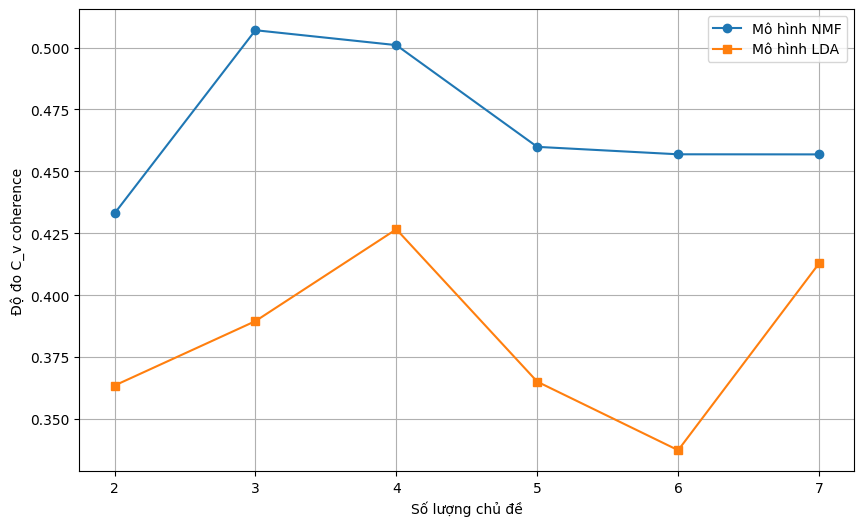

<Figure size 640x480 with 0 Axes>

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

n_components_values = [2, 3, 4, 5, 6, 7]
coherence_values_nmf = []
coherence_values_lda = []

for n in n_components_values:
    # Mô hình NMF
    nmf = build_pipe(NMF(random_state=444, n_components=n), TfidfVectorizer(max_df=0.95))
    nmf.fit(X_nouns_only)
    coherence_nmf = calculate_pipeline_coherence_gensim(nmf, X_nouns_only, 10)
    coherence_values_nmf.append(coherence_nmf)

    # Mô hình LDA
    lda = build_pipe(LatentDirichletAllocation(random_state=444, n_components=n, n_jobs=-1, learning_method='online'), TfidfVectorizer(max_df=0.95))
    lda.fit(X_nouns_only)
    coherence_lda = calculate_pipeline_coherence_gensim(lda, X_nouns_only, 10)
    coherence_values_lda.append(coherence_lda)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(n_components_values, coherence_values_nmf, marker='o', label='Mô hình NMF')
plt.plot(n_components_values, coherence_values_lda, marker='s', label='Mô hình LDA')

plt.xlabel('Số lượng chủ đề')
plt.ylabel('Độ đo C_v coherence')
plt.legend()
plt.grid()
plt.show()
plt.savefig("topic_model.png")

## Lưu model tốt nhất

In [ ]:
import joblib
joblib.dump(nmf, "nmf_topic_model.joblib")

## Learning curve

In [ ]:
import joblib
model = joblib.load("/content/sentiment_analysis_stacking_model.joblib")

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
!pip install yellowbrick

In [ ]:
from yellowbrick.model_selection import learning_curve

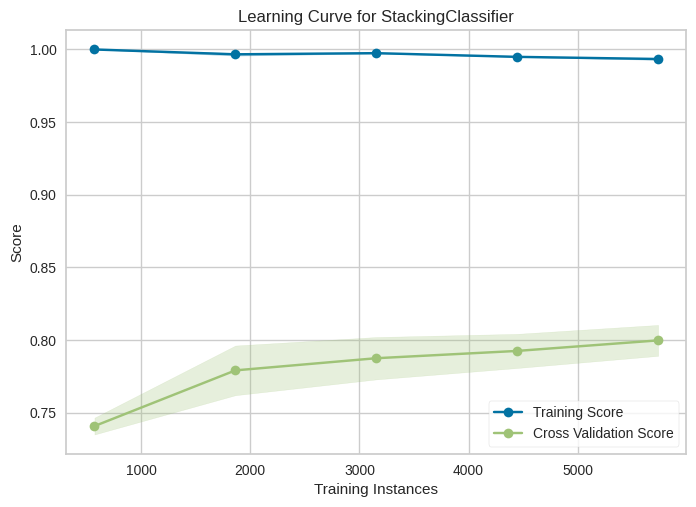

ValueError: ignored

In [ ]:
print(learning_curve(model, X, y, cv=5, scoring='accuracy'))